In [1]:
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb xorg-dev python-opengl libboost-all-dev libsdl2-dev swig

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package python-dev is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  python2-dev python2 python-dev-is-python3

E: Unable to locate package python-numpy
E: Package 'python-dev' has no installation candidate
E: Unable to locate package python-opengl


In [2]:
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym==0.22
!pip install pygame

In [3]:
import random
import math
import numpy as np
import gym
from gym.wrappers import Monitor
import matplotlib.pyplot as plt
from glob import glob
from base64 import b64encode
from IPython.display import HTML
from IPython import display as ipy_display
from gym import logger as gym_logger
from pyvirtualdisplay import Display

In [4]:
def wrap_env(env):
    env = Monitor(env, './video', force = True)
    return env

In [5]:
## Initialize the "Cart-Pole" environment
env = wrap_env(gym.make('CartPole-v0'))

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


In [6]:
## Defining the environment related constants

# Number of discrete states per state dimension
NUM_STATES = (1, 1, 6, 3)            # (x, dx, theta, dtheta)
# Number of discrete actions
NUM_ACTIONS = env.action_space.n                 # (left, right)
# Bounds for each discrete state
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))
STATE_BOUNDS[1] = [-0.5, 0.5]
STATE_BOUNDS[3] = [-math.radians(50), math.radians(50)]

In [7]:
## Convert continous states to discrete states
def state_to_discrete(state):
    state_indice = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            state_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]:
            state_index = NUM_STATES[i] - 1
        else:
            # Mapping the state bounds to the state array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_STATES[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_STATES[i]-1)/bound_width
            state_index = int(round(scaling*state[i] - offset))
        state_indice.append(state_index)
    return tuple(state_indice)

In [8]:
## Creating a Q-Table for each state-action pair
q_table = np.zeros(NUM_STATES + (NUM_ACTIONS,))
print(q_table)
print(q_table.shape)

# Create lists to contain total rewards and steps per episode
rList = []

## Learning related constants
MIN_EXPLORE_RATE = 0.01
MIN_LEARNING_RATE = 0.1

## Defining the simulation related constants
NUM_EPISODES = 500
MAX_STEP = 200
END_CONDITION = 100
SOLVED_STEP = 199



[[[[[0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]]]]]
(1, 1, 6, 3, 2)


In [9]:
def get_explore_rate(episode):
    if episode >= 24:
        return max(MIN_EXPLORE_RATE, min(1, 1.0 - math.log10((episode+1)/25)))
    else:
        return 1.0

In [10]:
def get_learning_rate(episode):
    if episode >= 24:
         return max(MIN_EXPLORE_RATE, min(0.5, 1.0 - math.log10((episode+1)/25)))
    else:
         return 1.0

In [11]:
## Initializing the learning related parameters
learning_rate = get_learning_rate(0)
explore_rate = get_explore_rate(0)
discount_factor = 0.99       # since the world is unchanging

end_counter = 0

for episode in range(NUM_EPISODES):
    # Reset the environment
    obv = env.reset()
    # the initial state
    state = state_to_discrete(obv)
    rAll = 0

    for t in range(MAX_STEP):
        # Select an action
        if random.random() < explore_rate:
            action = env.action_space.sample()
        # Select the action with the highest q
        else:
            action = np.argmax(q_table[state])

        # Execute the action
        new_obv, reward, done, info = env.step(action)

        # Observe the result
        new_state = state_to_discrete(new_obv)

        # Update Q-Table with new knowledge using learning rate
        q_target = reward + discount_factor * np.max(q_table[new_state])
        q_table[state + (action,)] += learning_rate * (q_target - q_table[state + (action,)])

        # Setting up for the next iteration
        state = new_state
        rAll += reward


        if done:
            print("Episode %d finished after %d time steps" % (episode, t))
            rList.append(rAll)
            # steps >= 199
            if (t >= SOLVED_STEP):
                end_counter += 1

            break;

  # It's considered done when it's solved over 100 times
    if end_counter > END_CONDITION:
        break

  # Update parameters
    explore_rate = get_explore_rate(episode)
    learning_rate = get_learning_rate(episode)

env.close()

Episode 0 finished after 17 time steps
Episode 1 finished after 12 time steps
Episode 2 finished after 17 time steps
Episode 3 finished after 34 time steps
Episode 4 finished after 10 time steps
Episode 5 finished after 19 time steps
Episode 6 finished after 12 time steps
Episode 7 finished after 35 time steps
Episode 8 finished after 14 time steps
Episode 9 finished after 14 time steps
Episode 10 finished after 15 time steps
Episode 11 finished after 19 time steps
Episode 12 finished after 22 time steps
Episode 13 finished after 14 time steps
Episode 14 finished after 27 time steps
Episode 15 finished after 17 time steps
Episode 16 finished after 23 time steps
Episode 17 finished after 30 time steps
Episode 18 finished after 15 time steps
Episode 19 finished after 26 time steps
Episode 20 finished after 29 time steps
Episode 21 finished after 11 time steps
Episode 22 finished after 13 time steps
Episode 23 finished after 12 time steps
Episode 24 finished after 17 time steps
Episode 25

In [12]:
def show_video():
    mp4_list = glob('video/*.mp4')
    print(mp4_list)
    if mp4_list:
        mp4 = mp4_list[2]
        video = open(mp4, 'r+b').read()
        encoded = b64encode(video)
        ipy_display.display(HTML(data='''
            <video alt="gameplay" autoplay controls style="height: 400px;">
                <source src="data:video/mp4;base64,%s" type="video/mp4" />
            </video>
        ''' % (encoded.decode('ascii'))))
    else:
        print('No video found')

In [13]:
show_video()

['video/openaigym.video.0.7690.video000216.mp4', 'video/openaigym.video.0.7690.video000000.mp4', 'video/openaigym.video.0.7690.video000001.mp4', 'video/openaigym.video.0.7690.video000125.mp4', 'video/openaigym.video.0.7690.video000064.mp4', 'video/openaigym.video.0.7690.video000027.mp4', 'video/openaigym.video.0.7690.video000008.mp4']


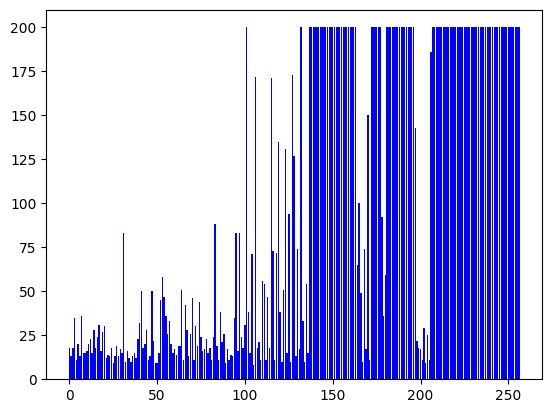

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.bar(range(len(rList)), rList, color="blue")
plt.show()